In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
plt.style.use('seaborn-v0_8-whitegrid')
# plt.style.use('ggplot')
# plt.style.use('seaborn-v0_8-notebook')

In [4]:
def class_rst_plot(X, y, model, xlim=(-2.25, 2.25), ylim = (-2.25, 2.25),cm=None, cm_bright=None, device='cpu'):
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    fig = plt.figure(figsize=(6, 5))

    h = .02  # step size in the mesh

    # x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    # y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    # 1st plot
#     ax = plt.subplot(1, 2, 1)

#     contour = ax.contourf(xx, yy, logits, 25, cmap=cm, alpha=.8)
#     # Plot the training points
#     ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
#     # Plot the testing points
#     #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xlabel(r'$x_1$')
#     ax.set_ylabel(r'$x_2$')
#     ax.set_title(r'$z = nnet(\mathbf{x})$')
#     ax.grid(False)
#     ax_c = plt.colorbar(contour)
#     ax_c.set_label("$z$", rotation=0)

    # 3rd plot
    ax = plt.subplot(1, 1, 1)

    ax.contour(xx, yy, yhat, levels=[.5], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.7, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=12, alpha=0.5, marker="x",cmap=cm_bright)
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])

    plt.tight_layout()
    
    return fig

## Linear Layer in Python

Since Python is row-majored, when it comes to implementation, we implement its transpose


$$
\LARGE
\texttt{Linear}(\mathbf{x}; \mathbf{W}, \mathbf{b}) = \texttt{x}@ \texttt{W}  +\texttt{b}
$$


* or in other words, $\texttt{Linear}(\mathbf{x}; \mathbf{W}, \mathbf{b}) = \mathbf{x}^\top\mathbf{W}^\top +\mathbf{b}^\top$


In particular, $\texttt{W}_{\text{in} \times \text{out}} \in \mathbb{R}^{\text{in} \times \text{out}}$

$$\texttt{W}= \begin{bmatrix} \mid &\mid &  \mid &\mid \\
\mathbf{w}_1 &\mathbf{w}_2 & \ldots & \mathbf{w}_{\text{out}} \\
\mid &\mid &  \mid &\mid 
\end{bmatrix}$$

* each column is a neuron's weight

In [5]:
class Linear:
  
    def __init__(self, in_size, out_size):
        self.weight = torch.randn((in_size, out_size), generator=g) / in_size**0.5
        self.bias = torch.zeros(out_size) 
  
    def __call__(self, x):
        self.out = x @ self.weight + self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [6]:
g = torch.Generator().manual_seed(123) # for reproducibility
layer = Linear(2, 10)
layer.weight, layer.bias

(tensor([[ 0.2386, -0.1257, -0.2146, -0.4158,  1.1179,  0.9200,  0.9018, -0.1421,
          -0.1135, -0.2839],
         [ 0.4920, -1.2771, -0.8194,  0.2301, -0.4465, -2.0082, -0.5550, -0.9967,
          -0.2882,  0.5624]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [7]:
x = torch.rand(2) # randomly generate input x a 2 element vector
z = layer(x) # apply linear layer to x
print(x, z)

tensor([0.8221, 0.7242]) tensor([ 0.5524, -1.0281, -0.7698, -0.1751,  0.5956, -0.6980,  0.3394, -0.8386,
        -0.3021,  0.1739])


## Activations

**Tanh**: 


$$\tanh(z) = \frac{e^{z} - e^{-z}}{e^{z}+ e^{-z}}$$


**ReLu** (Rectified linear unit): 

$$
\text{ReLu}(z) = \begin{cases}0 & z < 0\\ z & z\geq 0 \end{cases} =\max(z, 0)$$

In [8]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [9]:
class ReLu:
    def __call__(self, x):
        self.input = x
        self.out = torch.relu(x)
        return self.out
    def parameters(self):
        return []
    
    def backward(self, da):
        return (self.input > 0) * da

## Neural networks or MLPs

In [10]:
class MLP:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        yhat = x
        for layer in self.layers:
            yhat = layer(yhat)
        return yhat
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

## Loss functions for binary classification

$$
\large
\begin{align}
 \text{BCE_loss}(\hat{\mathbf{y}}, \mathbf{y}) = - \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln {\hat{y}^{(i)}}+ (1- y^{(i)}) \ln (1-{\hat{y}^{(i)}})
\end{align}
$$

In [11]:
def bce_loss_with_logits_naive(inputs, targets):
    losses = -1 * (targets * inputs.log() + (1-targets) * (1-inputs).log())
    return losses.mean()

The preferred approach

$$
\begin{align}
 \text{BCE_loss_with_logits}({\mathbf{z}}, \mathbf{y}) = - \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln \sigma(z^{(i)})+ (1- y^{(i)}) \ln (1-\sigma(z^{(i)}))
\end{align}
$$

* define the loss with the logits $z$ (the unconstrained output of the neural network) 
* in other words, combine the final logistic (sigmoid) activation with the loss function
* more details next time when we discuss backpropagation

In [12]:
def logit_BCE_loss(inputs, targets):
    """
    deal with boundary cases such as σ = 0 or 1, log(0) gracefully
    1/n * sum(y .* log.(σ) + (1 .- y).* log.(1 .- σ))
    rather you should use xlogy and xlog1py
    """
    sigmas = F.sigmoid(inputs) # apply transform on the logits
    losses = -1 * (torch.special.xlogy(targets, sigmas) + torch.special.xlog1py(1 - targets, - sigmas))
    return losses.mean()

In [13]:
# def bce_loss_with_logits(inputs, targets):
#     logses = torch.logsumexp(torch.cat((inputs, torch.zeros_like(inputs)), 1), 1, keepdim=True)
#     logsigmas = inputs - logses
#     log1msigmas = 0 - logses
#     losses = -1 * (targets * logsigmas + (1-targets) * log1msigmas)
#     return losses.mean()

## Demonstrations

#### Example dataset: non-linear classification data (three balls)

In [14]:
rng = np.random.default_rng(123)
n_ = 30
D1 = rng.standard_normal((n_, 2))
D2_1 = np.array([5, 5]) + rng.standard_normal((n_, 2))
D2_2 = np.array([-5, -5]) + rng.standard_normal((n_, 2))
D2 = np.vstack((D2_1, D2_2))
Xs_train_class = np.vstack((D1, D2))
ys_train_class = np.repeat([0, 1], [n_, 2* n_])
x_train_tensor_class = torch.as_tensor(Xs_train_class).float()
y_train_tensor_class = torch.as_tensor(ys_train_class.reshape(-1,1)).float()

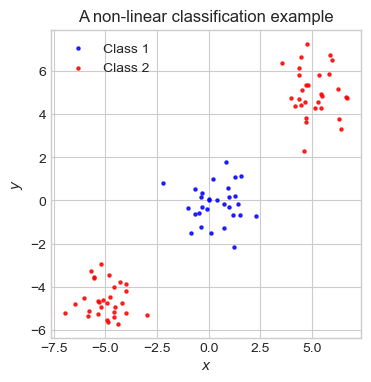

In [15]:
fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(D1[:, 0],D1[:, 1], s = 5, alpha=0.8, color='blue', label="Class 1")
ax.scatter(D2[:, 0],D2[:, 1], s = 5, alpha=0.8, color='red', label="Class 2")
ax.set(xlabel=r'$x$', ylabel=r'$y$', title='A non-linear classification example')
ax.legend()
fig.show()

Create a neural network

<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS3105/nnet-05.png" width="500"/>

In [16]:
g = torch.Generator().manual_seed(56678) # for reproducibility
n_hidden = 2
nnet_class = MLP([Linear(2, n_hidden), ReLu(), Linear(n_hidden, 1)])
parameters = nnet_class.parameters()

In [17]:
# need to tell PyTorch which variables' gradients are needed
for p in parameters:
    p.requires_grad = True

In [18]:
# number of epochs
n_epochs = 1000
losses_class = []
lr = 0.09
# For each epoch...
for epoch in range(n_epochs):
    yhat = nnet_class(x_train_tensor_class)
#     loss_batch = F.binary_cross_entropy_with_logits(yhat, y_train_tensor)    
    loss_batch = logit_BCE_loss(yhat, y_train_tensor_class)    
    for p in parameters:
        p.grad = None
    loss_batch.backward() 
    for p in parameters:
        p.data += -lr * p.grad
    losses_class.append(loss_batch.squeeze().data)
    if epoch % 200 == 1: 
        acc = ((nnet_class(x_train_tensor_class) > 0) == y_train_tensor_class).float().mean()
        print(f'Epoch {epoch} and the training accuracy is {acc.numpy():.4f}')

Epoch 1 and the training accuracy is 0.6111
Epoch 201 and the training accuracy is 0.9667
Epoch 401 and the training accuracy is 1.0000
Epoch 601 and the training accuracy is 1.0000
Epoch 801 and the training accuracy is 1.0000


Inspect the result:

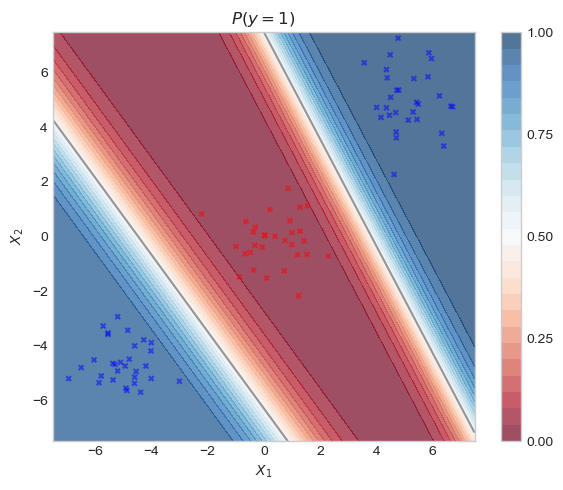

In [19]:
class_rst_plot(x_train_tensor_class, y_train_tensor_class, nnet_class, (-7.5, 7.5), (-7.5, 7.5));

## Non-linear classification data (smile dataset)

In [20]:
def generate_real_data(n):
    x1 = rng.random((n, 1)) - 0.5
    x2 = (x1 * x1)*3 + rng.standard_normal((n, 1)) * 0.1
    return np.hstack((x1, x2))

def generate_fake_data(n):
    theta = 2 * np.pi * rng.random((n, 1))
    r = rng.random((n, 1)) / 3
    x1 = r * np.cos(theta)
    x2 = r * np.sin(theta) + 0.5
    return np.hstack((x1, x2))
# Creating our data
train_size = 1000
real = generate_real_data(train_size)
fake = generate_fake_data(train_size)

Xs_train_smile = np.vstack((real, fake))
ys_train_smile = np.hstack((np.ones(real.shape[0]), np.zeros(fake.shape[0])))
test_size = 1000
real_test = generate_real_data(test_size)
fake_test = generate_fake_data(test_size)
Xs_test_smile = np.vstack((real_test, fake_test))
ys_test_smile = np.hstack((np.ones(real_test.shape[0]), np.zeros(fake_test.shape[0])))

In [21]:
x_train_tensor_smile = torch.as_tensor(Xs_train_smile).float()
y_train_tensor_smile = torch.as_tensor(ys_train_smile.reshape(-1, 1)).float()

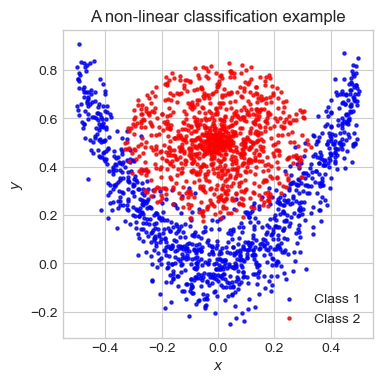

In [22]:
fig, ax = plt.subplots(figsize = (4,4))
ax.scatter(real[:, 0],real[:, 1], s = 5, alpha=0.8, color='blue', label="Class 1")
ax.scatter(fake[:, 0],fake[:, 1], s = 5, alpha=0.8, color='red', label="Class 2")
ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='A non-linear classification example')
ax.legend()
plt.show()

Create a neural network

<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS3105/nnet-16.png" width="500"/>

In [23]:
g = torch.Generator().manual_seed(12345) # for reproducibility
n_hidden1, n_hidden2 = 20, 3
act_fun = ReLu
nnet_smile = MLP([Linear(2, n_hidden1), act_fun(), Linear(n_hidden1, n_hidden2), act_fun(), Linear(n_hidden2, 1)])
parameters = nnet_smile.parameters()

for p in parameters:
    p.requires_grad = True

In [24]:
# number of epochs
n_epochs = 2000
losses_smile = []
lr = 0.1
# For each epoch...
for epoch in range(n_epochs):
    yhat = nnet_smile(x_train_tensor_smile)
    loss_batch = logit_BCE_loss(yhat, y_train_tensor_smile)    
    for p in parameters:
        p.grad = None
    loss_batch.backward() 
    for p in parameters:
        p.data += -lr * p.grad
    losses_class.append(loss_batch.squeeze().data)
    if epoch % 200 == 1: 
        acc = ((nnet_smile(x_train_tensor_smile) > 0) == y_train_tensor_smile).float().mean()
        print(f'Epoch {epoch} and the training accuracy is {acc.numpy():.4f}')

Epoch 1 and the training accuracy is 0.6365
Epoch 201 and the training accuracy is 0.9030
Epoch 401 and the training accuracy is 0.9495
Epoch 601 and the training accuracy is 0.9565
Epoch 801 and the training accuracy is 0.9605
Epoch 1001 and the training accuracy is 0.9600
Epoch 1201 and the training accuracy is 0.9610
Epoch 1401 and the training accuracy is 0.9635
Epoch 1601 and the training accuracy is 0.9665
Epoch 1801 and the training accuracy is 0.9670


Inspect the result

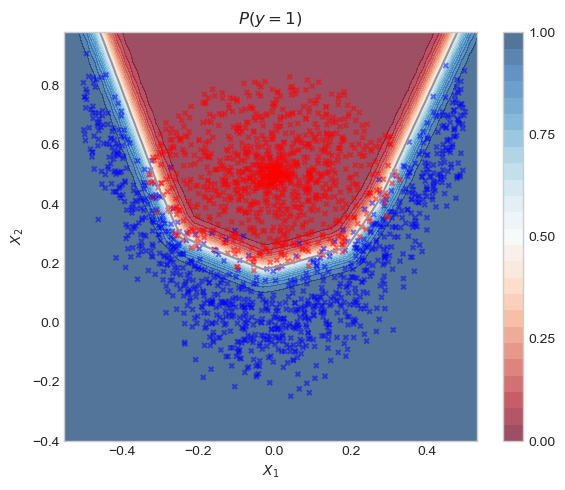

In [25]:
class_rst_plot(x_train_tensor_smile, y_train_tensor_smile, nnet_smile, (-.55, .55), (-0.4, 1));

## Non-linear regression dataset

In [26]:
def true_f(x):
    return -5 * np.tanh(0.5 * x) * (1. - np.tanh(0.5 * x)**2)
rng = np.random.default_rng(100)
x_input = np.linspace(-8, 8, 50)
y_output = true_f(x_input) + np.sqrt(0.05) * rng.standard_normal(len(x_input))

In [27]:
x_train_tensor_reg = torch.as_tensor(x_input.reshape(-1, 1)).float()
y_train_tensor_reg = torch.as_tensor(y_output.reshape(-1, 1)).float()

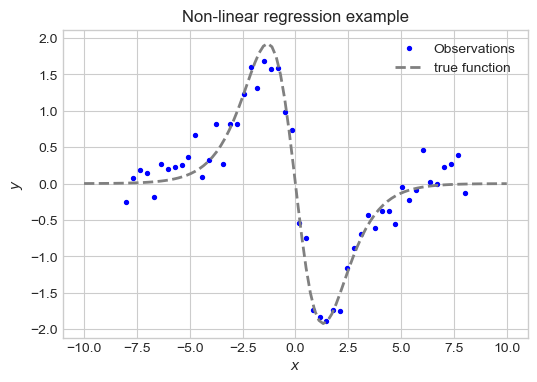

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x_input, y_output, s=8, color='blue', label="Observations")
xs = np.linspace(-10,10, 100)
ys = true_f(xs)
ax.plot(xs, ys, c="gray", linestyle='dashed',
     linewidth=2, label="true function")
ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='Non-linear regression example')
ax.legend()
plt.show()

In [29]:
def regression_rst_plot(X, y, model, xlim=(-10, 10), ylim=(-2, 2), device='cpu'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(X, y, s=8, color='blue', label="Observations")
    xs = np.linspace(xlim[0],xlim[1], 200)
    ys = model(torch.as_tensor(xs.reshape(-1, 1)).float().to(device)).detach().cpu().numpy().reshape(xs.shape)
    ax.plot(xs, ys, c="gray", linestyle='solid',
     linewidth=2, label="fitted function")
    ax.set(xlabel=r'$x$', ylabel=r'$y$',
       title='Regression result')
    ax.legend()
    return fig

The loss for regression

* mean squared error

$$\text{mse_loss} = \frac{1}{n} \sum_{i=1}^n \left (y^{(i)} - \hat{y}^{(i)} \right )^2$$

In [30]:
def mse_loss(inputs, targets):
    """
    1/n sum((y .- inputs)^2)
    """
    return 1/len(targets) * ((inputs - targets)**2).sum()

Let's first try with simple linear regression

In [31]:
lineareg = Linear(1, 1) # linear regression with one d input
parameters = lineareg.parameters()
for p in parameters:
    p.requires_grad = True

# number of epochs
n_epochs = 500
losses_reg = []
lr = 0.01
# For each epoch...
for epoch in range(n_epochs):
    yhat = lineareg(x_train_tensor_reg)
#     loss_batch = F.binary_cross_entropy_with_logits(yhat, y_train_tensor)    
    loss_batch = mse_loss(yhat, y_train_tensor_reg)    
    for p in parameters:
        p.grad = None
    loss_batch.backward() 
    for p in parameters:
        p.data += -lr * p.grad
    losses_reg.append(loss_batch.squeeze().data)
    if epoch % 100 == 1: 
#         acc = ((nnet_class(x_train_tensor_class) > 0) == y_train_tensor_class).float().mean()
        print(f'Epoch {epoch} and the training loss is {losses_reg[-1]:.4f}')

Epoch 1 and the training loss is 10.1164
Epoch 101 and the training loss is 0.7271
Epoch 201 and the training loss is 0.7271
Epoch 301 and the training loss is 0.7271
Epoch 401 and the training loss is 0.7271


Linear regression fails 

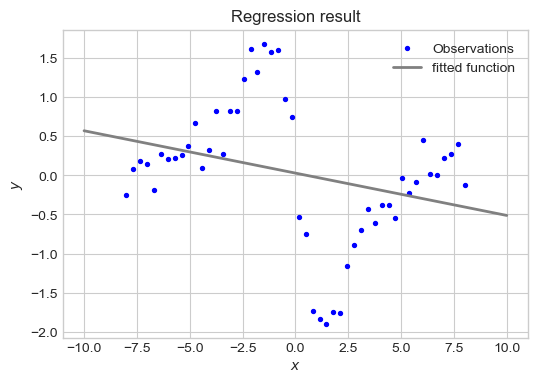

In [32]:
regression_rst_plot(x_train_tensor_reg, y_train_tensor_reg, lineareg);

Neural network:
$1 \Rightarrow 12 \Rightarrow 1$

<img src='https://leo.host.cs.st-andrews.ac.uk/figs/CS3105/nnet-17.png
' width = '350' />

In [33]:
act = Tanh # Tanh
nnet_reg = MLP([Linear(1, 12), act(), Linear(12, 1)])
parameters = nnet_reg.parameters()
for p in parameters:
    p.requires_grad = True

# number of epochs
n_epochs = 3000
losses_reg = []
lr = 0.005
# For each epoch...
for epoch in range(n_epochs):
    yhat = nnet_reg(x_train_tensor_reg)
    loss_batch = mse_loss(yhat, y_train_tensor_reg)    
    for p in parameters:
        p.grad = None
    loss_batch.backward() 
    for p in parameters:
        p.data += -lr * p.grad
    losses_reg.append(loss_batch.squeeze().data)
    if epoch % 200 == 1: 
        print(f'Epoch {epoch} and the training loss is {losses_reg[-1]:.4f}')

Epoch 1 and the training loss is 0.6298
Epoch 201 and the training loss is 0.2985
Epoch 401 and the training loss is 0.1698
Epoch 601 and the training loss is 0.1078
Epoch 801 and the training loss is 0.0774
Epoch 1001 and the training loss is 0.0620
Epoch 1201 and the training loss is 0.0539
Epoch 1401 and the training loss is 0.0494
Epoch 1601 and the training loss is 0.0467
Epoch 1801 and the training loss is 0.0450
Epoch 2001 and the training loss is 0.0439
Epoch 2201 and the training loss is 0.0431
Epoch 2401 and the training loss is 0.0426
Epoch 2601 and the training loss is 0.0421
Epoch 2801 and the training loss is 0.0417


Inspect the result 

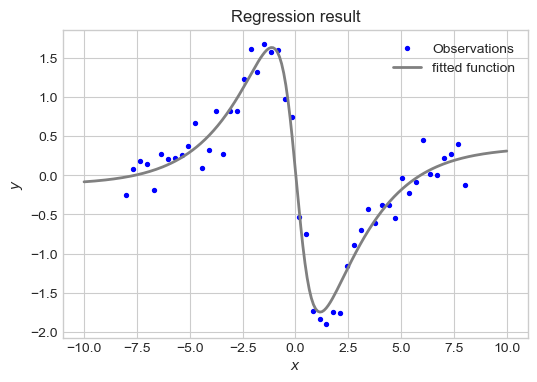

In [34]:
regression_rst_plot(x_train_tensor_reg, y_train_tensor_reg, nnet_reg);

## Exercise: Moon dataset

In [35]:
X, y = make_moons(n_samples=1500, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [37]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()
# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=25, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=25)

Text(0.5, 1.0, 'Moon data - Train')

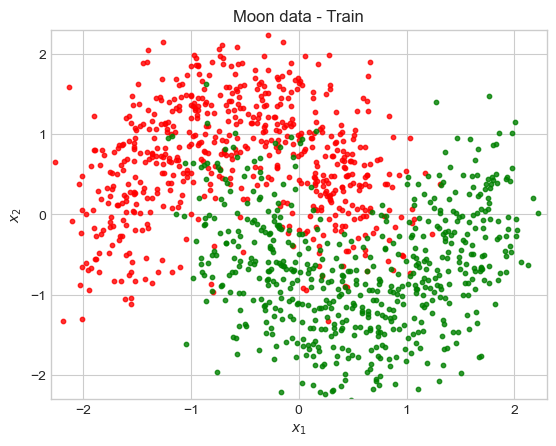

In [38]:
fig, ax = plt.subplots()
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
colors = ("red", "green", "blue")
for c in np.unique(y_train):
    ax.scatter(X_train[y_train == c, 0], X_train[y_train == c, 1], s=10, alpha=0.8, c=colors[c])
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_xlim([-2.3, 2.3])
ax.set_ylim([-2.3, 2.3])
ax.set_title('Moon data - Train')

In [39]:
input_dim, hidden_dim, output_dim = 2, 15, 1
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## fill the rest 


## training 



## inpect result